<a href="https://colab.research.google.com/github/ManelSoengas/DL_Task2/blob/main/DL_task2_RobertTuito_14_8_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NO utilizamos/Utilizamos los datos aumentados mediante la técnica de swapping. Además la arquitectura contempla:


1.   Dropout y early_stopping
2.   Asignación de pesos en función del peso de la clase.
3.   La configuración y arquitectura se mantienen.
4.   Uso del modelo RoBERTuito para tweets en español.

https://huggingface.co/pysentimiento/robertuito-base-cased
https://medium.com/@dataproducts/text-preprocessing-techniques-in-natural-language-processing-19a840bb7a4f



# **Cargar los recursos necesarios.**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.1 MB/s eta 0:00:00


#**Cargar los datos de entrada**

In [2]:
from sklearn.utils import shuffle
# Cargar datos preprocesados
#train_data = pd.read_csv('/content/EXIST2021_training.tsv', delimiter=',', encoding='latin1')
#test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', delimiter=',', encoding='latin1')

import pandas as pd

# Leer los archivos TSV y seleccionar las columnas deseadas y filtrar por idioma 'es'
test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', sep='\t', usecols=['text', 'language', 'task2']).loc[lambda df: df['language'] == 'es']
train_data = pd.read_csv('/content/swapp_EXIST2021_training.tsv', sep='\t', usecols=['text', 'language', 'task2']).loc[lambda df: df['language'] == 'es']
#swapping data_set training
# Mezclar los datos de entrenamiento
shuffled_train_data = shuffle(train_data, random_state=42)

# Mezclar los datos de prueba
shuffled_test_data = shuffle(test_data, random_state=42)

# **Visualizar estructura de los datos**

In [ ]:
shuffled_train_data.head(10)

,language,text,task2
4148,es,"Janis Joplin, la 'perla' rebelde que cambió el...",non-sexist
3715,es,Diga lo que diga una amiga de verdad hubiera d...,non-sexist
4892,es,"me quiero follar al osito bimbo, sus deliciosa...",non-sexist
6941,es,Perra sensación solo dime que quieres que nos ...,objectification
5630,es,@SatoshiJimenez @lublo8 @elconfidencial @vox_e...,sexual-violence
5516,es,@javicmrs @tressymaniqui Aquí le explico en qu...,sexual-violence
6645,es,ME VOY A PEGAR UN TIRO PENSANDO EN QUIÉN ES EL...,misogyny-non-sexual-violence
5224,es,"soy super Dino, no me hablen chica/os alejense...",non-sexist
3914,es,"""No se merece mi poder divino Mejor no lo aviv...",non-sexist
4507,es,@nicetobezombie Camisa de manga corta y corbat...,non-sexist


# **Distribución de la clase objetivo**

In [3]:

columna_clase_objetivo = "task2"

df = shuffled_train_data

# Contar la cantidad de categorías únicas en la columna de la clase objetivo
cantidad_categorias = df[columna_clase_objetivo].nunique()

# Contar la cantidad de muestras para cada categoría de la clase objetivo
muestras_por_categoria = df[columna_clase_objetivo].value_counts()

# Imprimir los resultados
print("Cantidad de categorías:", cantidad_categorias)
print("Muestras por categoría:")
print(muestras_por_categoria)
df.shape[0]

Cantidad de categorías: 6
Muestras por categoría:
non-sexist                      3076
ideological-inequality           834
stereotyping-dominance           740
misogyny-non-sexual-violence     672
objectification                  424
sexual-violence                  295
Name: task2, dtype: int64


6041

# **Carga de los recursos RoBERTuito**

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            truncation_strategy='longest_first',
            return_attention_mask=True

        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [6]:
def tokenize_robertuito(data, max_len=MAX_LEN):
  input_ids = []
  attention_masks = []

  for text in data:
    encoded = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=max_len,
      padding='max_length',
      truncation=True,
      return_attention_mask=True
    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids), np.array(attention_masks)

In [7]:

# Cargar el tokenizer de Robertuito

#tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("pysentimiento/robertuito-base-cased")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'RobertaTokenizerFast'.


# **Configuración**

In [5]:
MAX_LEN=255


In [8]:
X = shuffled_train_data['text'].values
y = shuffled_train_data['task2'].values
Z = shuffled_test_data['text'].values
z = shuffled_test_data['task2'].values

In [9]:
# Dividir los datos en entrenamiento y prueba
train_text, val_text, train_task2, val_task2 = train_test_split(X, y, test_size=0.2, random_state=42)

# **Codificación**

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

# Crear un objeto LabelEncoder para convertir las etiquetas de clase en valores numéricos
label_encoder = LabelEncoder()

# Ajustar el encoder con los datos de train_task2
label_encoder.fit(train_task2)

# Aplicar la transformación a los conjuntos de datos
train_task2_encoded = label_encoder.transform(train_task2)
val_task2_encoded = label_encoder.transform(val_task2)
z_encoded = label_encoder.transform(z)

# Ahora puedes usar train_task2_encoded, val_task2_encoded y z_encoded en tu modelo de clasificación

# Si deseas codificar las etiquetas de clase como one-hot encoded, utiliza OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Ajustar el encoder one-hot con las etiquetas codificadas numéricamente
onehot_encoder.fit(train_task2_encoded.reshape(-1, 1))

# Aplicar la transformación one-hot a los conjuntos de datos
train_task2_onehot = onehot_encoder.transform(train_task2_encoded.reshape(-1, 1))
val_task2_onehot = onehot_encoder.transform(val_task2_encoded.reshape(-1, 1))
z_onehot = onehot_encoder.transform(z_encoded.reshape(-1, 1))

# Ahora train_task2_onehot, val_task2_onehot y z_onehot contienen las etiquetas de clase codificadas como one-hot

Estoy utilizando **LabelBinarizer** de Scikit-Learn para convertir las etiquetas de clase en codificación one-hot. La principal diferencia aquí es que uso fit una vez para ajustar el codificador con las etiquetas de clase, y luego uso transform para convertir las etiquetas de cada conjunto de datos (entrenamiento, validación, prueba) en codificación one-hot. Esto asegura que las mismas transformaciones se apliquen a todas las etiquetas, lo que es importante para mantener la consistencia.



In [11]:
from sklearn.preprocessing import LabelBinarizer

etiquetas_clase = ["non-sexist", "ideological-inequality", "stereotyping-dominance", "misogyny-non-sexual-violence", "sexual-violence", "objectification"]

# Crear un objeto LabelBinarizer para convertir las etiquetas de clase en one-hot encoding
label_binarizer = LabelBinarizer()

# Ajustar el LabelBinarizer con las etiquetas de clase
label_binarizer.fit(etiquetas_clase)

# Transformar las etiquetas de clase en one-hot encoding
train_task2_onehot = label_binarizer.transform(train_task2)
val_task2_onehot = label_binarizer.transform(val_task2)
z_onehot = label_binarizer.transform(z)

In [ ]:
#import numpy as np
#train_input_ids, train_attention_masks = tokenize_roberta(train_text, MAX_LEN)
#val_input_ids, val_attention_masks = tokenize_roberta(val_text, MAX_LEN)
#test_input_ids, test_attention_masks = tokenize_roberta(Z, MAX_LEN)

In [12]:
# Utilizar el modelo Robertuito en lugar de RoBERTa
import numpy as np
train_input_ids, train_attention_masks = tokenize_robertuito(train_text, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_robertuito(val_text, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_robertuito(Z, MAX_LEN)

In [13]:
print(train_input_ids.shape)
print(val_input_ids.shape)
print(test_input_ids.shape)

(4832, 255)
(1209, 255)
(2160, 255)


# **Cáculo y asignación de los pesos**

In [14]:
import numpy as np

# Frecuencias de las categorías
muestras_por_categoria = {
    "non-sexist": 3076,
    "ideological-inequality": 834,
    "stereotyping-dominance": 740,
    "misogyny-non-sexual-violence": 672,
    "sexual-violence": 424,
    "objectification": 295
}

total_muestras = sum(muestras_por_categoria.values())

# Calcular las frecuencias relativas
frecuencias_relativas = {cat: count / total_muestras for cat, count in muestras_por_categoria.items()}

# Calcular los pesos inversamente proporcionales a las frecuencias
pesos = {cat: 1 / freq for cat, freq in frecuencias_relativas.items()}

# Normalizar los pesos
suma_pesos = sum(pesos.values())
pesos_normalizados = {cat: weight / suma_pesos for cat, weight in pesos.items()}

print(pesos_normalizados)


{'non-sexist': 0.03214997553630002, 'ideological-inequality': 0.11857712799719292, 'stereotyping-dominance': 0.1336396280400796, 'misogyny-non-sexual-violence': 0.14716268563937335, 'sexual-violence': 0.2332389734661766, 'objectification': 0.33523160932087753}


In [15]:
import tensorflow as tf

# Crear el tensor de pesos para la función de pérdida
pesos_array = np.array(list(pesos_normalizados.values()))
pesos_tensor = tf.constant(pesos_array, dtype=tf.float32)

In [16]:
import tensorflow as tf

def create_multiclass_model(robertuito_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    #loss = tf.keras.losses.SparseCategoricalCrossentropy()
    #accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    #loss = tf.keras.losses.CategoricalCrossentropy()
    loss = weighted_categorical_crossentropy  # Utilizamos la función con pesos

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    output = robertuito_model([input_ids, attention_masks])
    output = output[1]

    # Agregar Dropout
    output = tf.keras.layers.Dropout(0.5)(output)

    # Cambiar la salida para clasificación multiclase (6 clases)
    output = tf.keras.layers.Dense(6, activation='softmax')(output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compilar el modelo
    # Cambiar la métrica de BinaryAccuracy a CategoricalAccuracy
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Compilar el modelo
    model.compile(opt, loss=loss, metrics=[accuracy])

    # Agregar Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')

    return model, early_stopping

    # Función de pérdida ponderada
#def weighted_categorical_crossentropy(y_true, y_pred):
    # Aplicar los pesos solo a las muestras positivas (las que tienen etiqueta 1)
    #weights = tf.reduce_sum(pesos_tensor * y_true, axis=1)
    #unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    #weighted_loss = unweighted_loss * weights
    #return tf.reduce_mean(weighted_loss)

    # Función de pérdida ponderada
def weighted_categorical_crossentropy(y_true, y_pred):
    # Convertir y_true a float32
    y_true = tf.cast(y_true, dtype=tf.float32)
    # Aplicar los pesos solo a las muestras positivas (las que tienen etiqueta 1)
    weights = tf.reduce_sum(pesos_tensor * y_true, axis=1)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)



In [17]:
#roberta_model = TFRobertaModel.from_pretrained('roberta-base')
#robertuito_model = TFRobertuitoModel.from_pretrained("pysentimiento/robertuito-base-cased")
from transformers import TFRobertaModel

robertuito_model = TFRobertaModel.from_pretrained("pysentimiento/robertuito-base-cased", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [18]:
#model = create_model(roberta_model, MAX_LEN)
model, early_stopping = create_multiclass_model(robertuito_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 255)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  108787200  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 255,                                           

In [19]:
#history_2 = model.fit([train_input_ids,train_attention_masks], train_task2_onehot, validation_data=([val_input_ids,val_attention_masks], val_task2_onehot), epochs=8, batch_size=16)
history_2 = model.fit(
    [train_input_ids, train_attention_masks], train_task2_onehot,
    validation_data=([val_input_ids, val_attention_masks], val_task2_onehot),
    epochs=8,
    batch_size=16,
    callbacks=[early_stopping]  # Aquí se añade la devolución anticipada como callback
)

Epoch 1/8
302/302 [==============================] - 337s 969ms/step - loss: 0.2172 - categorical_accuracy: 0.4259 - val_loss: 0.1628 - val_categorical_accuracy: 0.5095
Epoch 2/8
302/302 [==============================] - 259s 859ms/step - loss: 0.1508 - categorical_accuracy: 0.5675 - val_loss: 0.1145 - val_categorical_accuracy: 0.6460
Epoch 3/8
302/302 [==============================] - 279s 926ms/step - loss: 0.1046 - categorical_accuracy: 0.6805 - val_loss: 0.0920 - val_categorical_accuracy: 0.7221
Epoch 4/8
302/302 [==============================] - 278s 921ms/step - loss: 0.0685 - categorical_accuracy: 0.7742 - val_loss: 0.0790 - val_categorical_accuracy: 0.7825
Epoch 5/8
302/302 [==============================] - 258s 853ms/step - loss: 0.0435 - categorical_accuracy: 0.8413 - val_loss: 0.0781 - val_categorical_accuracy: 0.8238
Epoch 6/8
302/302 [==============================] - 277s 919ms/step - loss: 0.0280 - categorical_accuracy: 0.8887 - val_loss: 0.0772 - val_categorical_acc

In [20]:
result_roberta = model.predict([test_input_ids,test_attention_masks])


68/68 [==============================] - 39s 530ms/step


In [21]:
# Evaluar el modelo
evaluation = model.evaluate([test_input_ids, test_attention_masks], z_onehot)

# Imprimir los resultados de la evaluación
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

68/68 [==============================] - 36s 528ms/step - loss: 0.2524 - categorical_accuracy: 0.6532
Loss: 0.2523668110370636
Accuracy: 0.6532407402992249


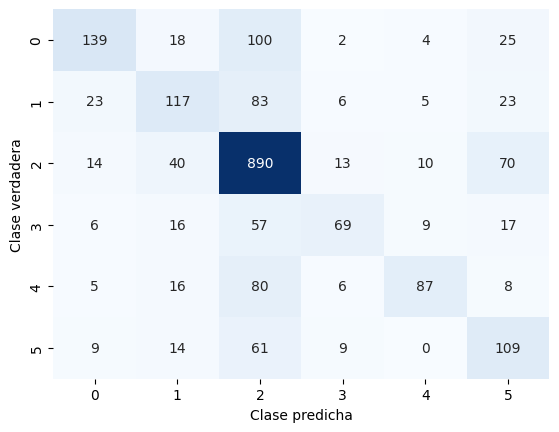

In [22]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que z_test.argmax(1) son las etiquetas reales y y_pred_roberta.argmax(1) son las etiquetas predichas
cm = confusion_matrix(z_onehot.argmax(1), y_pred_roberta.argmax(1))

# Crear un heatmap de la matriz de confusión
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Añadir etiquetas a los ejes
plt.xlabel("Clase predicha")
plt.ylabel("Clase verdadera")

# Mostrar el gráfico
plt.show()

Se utiliza Robertutio para tweets en español. Los tweets no se preprocesan, no se amplina datos y se utilizan pesos para compensar las clases minoritarias. learning_rate = 0.00001, batchsize= 32, epochs= 8.


#Resultados:
##Training:


```
Epoch 1/8
89/89 [==============================] - 211s 2s/step - loss: 0.2401 - categorical_accuracy: 0.4382 - val_loss: 0.2023 - val_categorical_accuracy: 0.5106
Epoch 2/8
89/89 [==============================] - 150s 2s/step - loss: 0.2062 - categorical_accuracy: 0.4883 - val_loss: 0.1791 - val_categorical_accuracy: 0.5444
Epoch 3/8
89/89 [==============================] - 159s 2s/step - loss: 0.1760 - categorical_accuracy: 0.5547 - val_loss: 0.1578 - val_categorical_accuracy: 0.5712
Epoch 4/8
89/89 [==============================] - 150s 2s/step - loss: 0.1496 - categorical_accuracy: 0.6052 - val_loss: 0.1481 - val_categorical_accuracy: 0.5994
Epoch 5/8
89/89 [==============================] - 158s 2s/step - loss: 0.1217 - categorical_accuracy: 0.6585 - val_loss: 0.1412 - val_categorical_accuracy: 0.6206
Epoch 6/8
89/89 [==============================] - 150s 2s/step - loss: 0.1003 - categorical_accuracy: 0.7225 - val_loss: 0.1443 - val_categorical_accuracy: 0.6361
Epoch 7/8
89/89 [==============================] - 158s 2s/step - loss: 0.0792 - categorical_accuracy: 0.7705 - val_loss: 0.1441 - val_categorical_accuracy: 0.6516
```
##Evaluación:



```
68/68 [==============================] - 36s 529ms/step - loss: 0.1646 - categorical_accuracy: 0.6324
Loss: 0.16464786231517792
Accuracy: 0.6324074268341064
```






Se utiliza Robertutio para tweets en español. Los tweets no se preprocesan, no se amplina datos y se utilizan pesos para compensar las clases minoritarias. learning_rate = 0.00001, batchsize= 16, epochs= 8.

#Training:



```
Epoch 1/8
177/177 [==============================] - 218s 944ms/step - loss: 0.2343 - categorical_accuracy: 0.4470 - val_loss: 0.1883 - val_categorical_accuracy: 0.5148
Epoch 2/8
177/177 [==============================] - 162s 918ms/step - loss: 0.1847 - categorical_accuracy: 0.5297 - val_loss: 0.1591 - val_categorical_accuracy: 0.5684
Epoch 3/8
177/177 [==============================] - 162s 915ms/step - loss: 0.1446 - categorical_accuracy: 0.5992 - val_loss: 0.1434 - val_categorical_accuracy: 0.6065
Epoch 4/8
177/177 [==============================] - 161s 912ms/step - loss: 0.1114 - categorical_accuracy: 0.6797 - val_loss: 0.1398 - val_categorical_accuracy: 0.6347
Epoch 5/8
177/177 [==============================] - 162s 913ms/step - loss: 0.0818 - categorical_accuracy: 0.7560 - val_loss: 0.1443 - val_categorical_accuracy: 0.6460
Epoch 6/8
177/177 [==============================] - 161s 911ms/step - loss: 0.0597 - categorical_accuracy: 0.8157 - val_loss: 0.1535 - val_categorical_accuracy: 0.6756
```

#Evaluación:



```
68/68 [==============================] - 37s 539ms/step - loss: 0.1856 - categorical_accuracy: 0.6338
Loss: 0.18560223281383514
Accuracy: 0.6337962746620178
```






Se utiliza Robertutio para tweets en español. Los tweets no se preprocesan,  se amplian datos medainte técnica swapping y se utilizan pesos para compensar las clases minoritarias. learning_rate = 0.00001, batchsize= 32/16, epochs= 8.

#Training: batct_size= 32



```
Epoch 1/8
151/151 [==============================] - 335s 2s/step - loss: 0.2241 - categorical_accuracy: 0.4005 - val_loss: 0.1738 - val_categorical_accuracy: 0.5203
Epoch 2/8
151/151 [==============================] - 284s 2s/step - loss: 0.1689 - categorical_accuracy: 0.5248 - val_loss: 0.1319 - val_categorical_accuracy: 0.6055
Epoch 3/8
151/151 [==============================] - 284s 2s/step - loss: 0.1274 - categorical_accuracy: 0.6190 - val_loss: 0.1089 - val_categorical_accuracy: 0.6816
Epoch 4/8
151/151 [==============================] - 284s 2s/step - loss: 0.0959 - categorical_accuracy: 0.7028 - val_loss: 0.0953 - val_categorical_accuracy: 0.7130
Epoch 5/8
151/151 [==============================] - 263s 2s/step - loss: 0.0712 - categorical_accuracy: 0.7676 - val_loss: 0.0879 - val_categorical_accuracy: 0.7535
Epoch 6/8
151/151 [==============================] - 283s 2s/step - loss: 0.0499 - categorical_accuracy: 0.8216 - val_loss: 0.0835 - val_categorical_accuracy: 0.8007
Epoch 7/8
151/151 [==============================] - 283s 2s/step - loss: 0.0345 - categorical_accuracy: 0.8624 - val_loss: 0.0830 - val_categorical_accuracy: 0.8131
Epoch 8/8
151/151 [==============================] - 283s 2s/step - loss: 0.0251 - categorical_accuracy: 0.9011 - val_loss: 0.0824 - val_categorical_accuracy: 0.8255
```
#Evaluación:


```
68/68 [==============================] - 38s 555ms/step - loss: 0.2027 - categorical_accuracy: 0.6495
Loss: 0.2026636004447937
Accuracy: 0.6495370268821716
```




#Training: batct_size= 16



```
Epoch 1/8
302/302 [==============================] - 337s 969ms/step - loss: 0.2172 - categorical_accuracy: 0.4259 - val_loss: 0.1628 - val_categorical_accuracy: 0.5095
Epoch 2/8
302/302 [==============================] - 259s 859ms/step - loss: 0.1508 - categorical_accuracy: 0.5675 - val_loss: 0.1145 - val_categorical_accuracy: 0.6460
Epoch 3/8
302/302 [==============================] - 279s 926ms/step - loss: 0.1046 - categorical_accuracy: 0.6805 - val_loss: 0.0920 - val_categorical_accuracy: 0.7221
Epoch 4/8
302/302 [==============================] - 278s 921ms/step - loss: 0.0685 - categorical_accuracy: 0.7742 - val_loss: 0.0790 - val_categorical_accuracy: 0.7825
Epoch 5/8
302/302 [==============================] - 258s 853ms/step - loss: 0.0435 - categorical_accuracy: 0.8413 - val_loss: 0.0781 - val_categorical_accuracy: 0.8238
Epoch 6/8
302/302 [==============================] - 277s 919ms/step - loss: 0.0280 - categorical_accuracy: 0.8887 - val_loss: 0.0772 - val_categorical_accuracy: 0.8304
Epoch 7/8
302/302 [==============================] - 278s 920ms/step - loss: 0.0182 - categorical_accuracy: 0.9220 - val_loss: 0.0810 - val_categorical_accuracy: 0.8536
Epoch 8/8
302/302 [==============================] - 277s 919ms/step - loss: 0.0127 - categorical_accuracy: 0.9410 - val_loss: 0.0848 - val_categorical_accuracy: 0.8586
```

#Evaluación:


```
68/68 [==============================] - 36s 528ms/step - loss: 0.2524 - categorical_accuracy: 0.6532
Loss: 0.2523668110370636
Accuracy: 0.6532407402992249
```

